## Sheet 2: Slow Feature Analysis - Luke Longren & Sujitkumar Gavali

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as LA
import seaborn as sns
from fractions import Fraction
from helper import gaussian_spectrum_1D

In [28]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
plt.rcParams.update({'font.size': 12})
plt.rcParams["figure.figsize"] = (14,8)

## Exercise 1: Slow Feature Analysis on two independent signals

To begin with, we focus on linear SFA transformations on a 2-dimensional time-dependent signal:

### 1. Write a function that generates a random signal of length $T$ and applies gaussian\_spectrum\_1D to it.

In [29]:
def gaussian_filter(T, epsilon):
    # generate a random signal to input into the filter function
    # T: length of the signal
    # epsilon: width of the Gaussian PSD (power spectral density)
    mean = 0  # zero mean
    std = 1  # unit variance
    rand_signal = np.random.normal(mean, std, T)
    # return the filtered signal
    return gaussian_spectrum_1D(rand_signal, epsilon, T)

### 2. Use the function from the task above to generate two independent 1D-signals.
### Normalise the signals, so that both have zero mean and unit variance. Plot both signals into a single figure. 

In [30]:
np.random.seed(111)
length = 1000  # number of samples
tau_1 = 30  # small tau makes a larger PSD
tau_2 = 100  # large tau makes a smaller PSD
signal1 = gaussian_filter(T=length, epsilon=1/(tau_1**2))  # signal with tau=30
signal2 = gaussian_filter(T=length, epsilon=1/(tau_2**2))  # signal with tau=100

In [31]:
#normalise the signals, divide signal by mean signal
norm_signal1 = signal1 / np.mean(signal1)
norm_signal2 = signal2 / np.mean(signal2)

plt.plot(norm_signal1, label=r'$\tau_1 = %i$' %tau_1)
plt.plot(norm_signal2, label=r'$\tau_2 = %i$' %tau_2)
plt.title('Independent 1D-signals')
plt.ylabel('signal')
plt.xlabel('sample #')
plt.legend(loc=1)
plt.grid()
plt.show()

### How does $τ$ influence the characteristics of the signals?

For a small $\tau$, and thus a large PSD, the normalized signal has a larger magnitude than a large $\tau$.

This can be seen in the graph above, where the blue signal with $\tau_1 = 30$ has larger peaks than the orange signal with $\tau=100$.

### 3. We will now perform linear SFA to see whether we can generate a slow signal by linearly combining both signals.
### First join them into a single 2x1000 matrix $X$. 

In [32]:
X = [norm_signal1, norm_signal2]
print('Dimensions of X:', np.shape(X))

Dimensions of X: (2, 1000)


### Compute the joint covariance matrix of both signals $C$ as well as the matrix of second moments of the temporal derivative $C˙$.

## <font color='black'> $ C = cov(X) ,  \dot{C} = \dot{X} \dot{X}^{\top} / (T-1) $

In [33]:
covariance = np.cov(X)  # calculate the joint covariance matrix
der_X = np.diff(X)  # calculate the derivative of X
der_covariance = der_X @ der_X.T / (length-1)  # calculate the msm of temporal derivative
print('Dimensions of C:', np.shape(covariance))
print('Dimensions of C\':', np.shape(der_covariance))

Dimensions of C: (2, 2)
Dimensions of C': (2, 2)


### Next, to perform SFA, we need to solve the Generalised Eigenvalue Problem of both matrices.
### Normalise the eigenvectors to length 1.

In [34]:
# based upon the LA.eig documentation, this function is of the form:  a  vr[:,i] = w[i]  b  vr[:,i]
eig_values, eig_vectors = LA.eig(a=der_covariance, b=covariance)
print('Dimensions of eigenvalues and eigenvectors are', np.shape(eig_values), ',', np.shape(eig_vectors), ', respectively')

Dimensions of eigenvalues and eigenvectors are (2,) , (2, 2) , respectively


In [35]:
print(eig_vectors, 'Eigenvectors')

[[-0.78672785  0.07492551]
 [ 0.61729999  0.99718913]] Eigenvectors


In [36]:
# now to normalize the eigenvectors. let's just write a function to do that
def norm_vectors(eig_vectors):
    a = eig_vectors[0]
    b = eig_vectors[1]
    constant_1 = 1 / (a[0]**2 + b[0]**2)
    constant_2 = 1 / (a[1]**2 + b[1]**2)
    return np.array([[a[0] * constant_1, a[1] * constant_2], 
                     [b[0] * constant_1, b[1] * constant_2]])

In [37]:
norm_eig_vectors = norm_vectors(eig_vectors)
# check the output
# print(norm_eig_vectors[0,0]**2 + norm_eig_vectors[1,0]**2)
# print(norm_eig_vectors[0,1]**2 + norm_eig_vectors[1,1]**2)

### 4. The eigenvectors determine how the input signals are mixed by the SFA to generate the new (slow) signals. 
### What kind of mixture do you ideally expect given how the data was generated? 

As the data was generated by randomly taking points from a Gaussian spectrum, one would expect that the new signal would also be random.

### What does the empirical mixture look like, judging from the extracted eigenvectors?

Let's inspect the eigenvectors we have found:

In [38]:
print(norm_eig_vectors, 'Normalized Eigenvectors')

[[-0.78672785  0.07492551]
 [ 0.61729999  0.99718913]] Normalized Eigenvectors


### 5. Repeat task 3 with different signal sample sizes (ranging logarithmically from 10 −100k in 20 steps) 
### and store the resulting normalised eigenvectors.

In [39]:
def SFA(sample_size, tau1, tau2):  # Slow Feature Analysis
    length = sample_size  # number of samples
    signal1 = gaussian_filter(T=length, epsilon=1/(tau_1**2))  # signal with tau=100
    signal2 = gaussian_filter(T=length, epsilon=1/(tau_2**2))  # signal with tau=30
    #normalize the signals
    norm_signal1 = signal1 / np.mean(signal1)
    norm_signal2 = signal2 / np.mean(signal2)
    X = [norm_signal1, norm_signal2]
    covariance = np.cov(X)  # calculate the joint covariance matrix
    der_X = np.diff(X)  # calculate the derivative of X
    der_covariance = der_X @ der_X.T / (length-1)  # calculate the msm of temporal derivative
    eig_values, eig_vectors = LA.eig(a=der_covariance, b=covariance)
    return norm_vectors(eig_vectors),eig_values  # function returns the normalized eigen vectors

In [40]:
sample_size = np.logspace(1, 5, 20)  # range from 10^1 to 10^5
norm_vectors_sample = np.array([SFA(int(sample_size[i]), 30, 100)[0] for i in range(len(sample_size))])
print('Dimensions of the eigenvectors:', np.shape(norm_vectors_sample))

Dimensions of the eigenvectors: (20, 2, 2)


### Plot the four individual components of the eigenvectors against the number of samples.

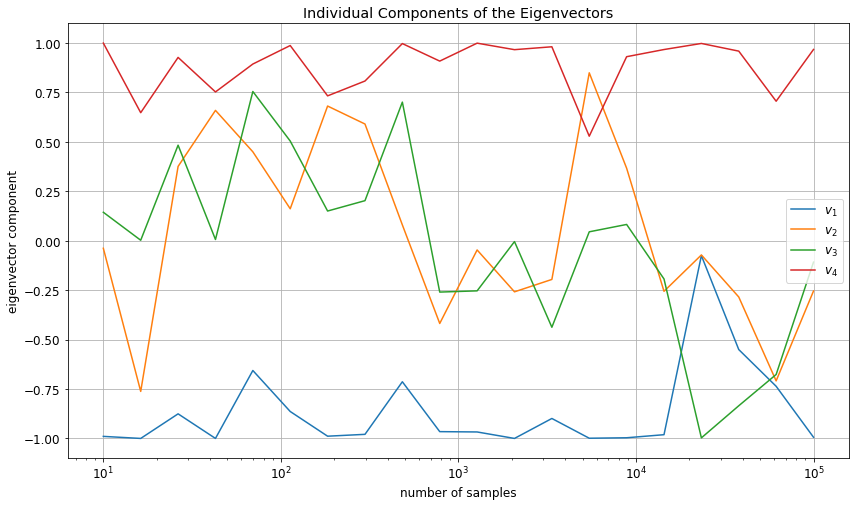

In [41]:
plt.plot(sample_size, norm_vectors_sample[:, 0, 0], label='$v_1$')
plt.plot(sample_size, norm_vectors_sample[:, 0, 1], label='$v_2$')
plt.plot(sample_size, norm_vectors_sample[:, 1, 0], label='$v_3$')
plt.plot(sample_size, norm_vectors_sample[:, 1, 1], label='$v_4$')
plt.title('Individual Components of the Eigenvectors')
plt.ylabel('eigenvector component')
plt.xlabel('number of samples')
plt.xscale('log')
plt.legend(loc=5)
plt.grid()
plt.show()

### How does the SFA-mixture change depending on the length of the input signal? Can you give an intuition why?

Based upon what we can tell from our data analysis, the dependency is random.

The intuition for why this is comes from the fact that these two input signals are independent from each other. Therefore, it would make sense that changing the length of the input signal would have a random affect on the SFA-mixture change.

### 6. How do the eigenvalues depend on the $τ$ ’s that you chose?

C:\Users\lcube\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  import sys
C:\Users\lcube\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  


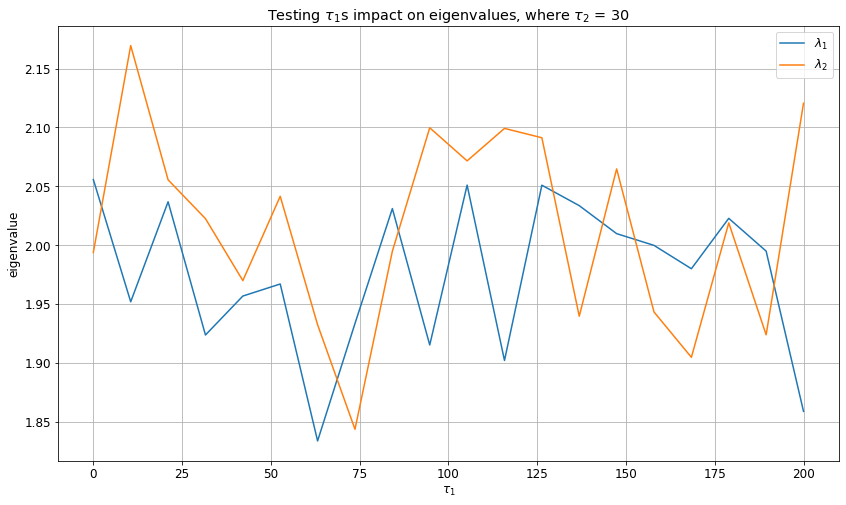

In [42]:
test_number = 20
test_result1 = np.zeros(test_number)
test_result2 = np.zeros(test_number)
test_tau = np.linspace(0, test_number*10, test_number)
for i in range(test_number):
    fixed_tau = 30
    test_result1[i] = SFA(sample_size=1000, tau1=fixed_tau, tau2=test_tau[i])[1][0]
    test_result2[i] = SFA(sample_size=1000, tau1=fixed_tau, tau2=test_tau[i])[1][1]
plt.plot(test_tau, test_result1, label='$\lambda_1$')
plt.plot(test_tau, test_result2, label='$\lambda_2$')
plt.title(r'Testing $\tau_1$s impact on eigenvalues, where $\tau_2$ = %i' %fixed_tau)
plt.xlabel(r'$\tau_1$')
plt.ylabel('eigenvalue')
plt.legend()
plt.grid()
plt.show()

And here again, the input signals are independent. Thus, changing $\tau$ would impact the respective eigenvalue randomly.

## Exercise 2: SFA on a high-dimensional correlated signal

### 1. Generate a 1D-image of length L = 10,000 pixels with the same power spectral density as above, but with $\epsilon$ = 0.04

In [43]:
image_length = 10000
signal = gaussian_filter(T=image_length, epsilon=0.04)
norm_signal = signal / np.mean(signal)

In [44]:
plt.eventplot(norm_signal, orientation='horizontal', linewidths=0.5, color='k')
#plt.plot(norm_signal, color='k', linewidth=0.25)
plt.tick_params(axis='y', which='both', left=False, labelleft=False)
plt.xlabel('1D Image [px]')
plt.xlim(-500, 500)  # the center 10th
plt.show()

### 2. Extract a time-dependent receptive field input by sliding a window of length $l =100$ pixels across the entire image.
### Generate a matrix $X$ containing the complete receptive field input recorded while the window is sliding over the image.

In [45]:
window_length = 100  # length of window [px]
sample_number = image_length - window_length
# let's generate the empty time-dependent receptive field input array
# we'll do this by creating an array from the pixel to the pixel plus the window size
X = np.array([norm_signal[i:i+window_length] for i in range(sample_number)]).T
print(np.shape(X))

(100, 9900)


### Make sure that the average input to each pixel of the receptive field is zero, i.e. each row of the matrix should have zero-mean.

In [46]:
# now to make sure we have zero-mean
norm_X = X - np.mean(X, axis=0)  # subtract mean to get average value of zero
print(np.mean(norm_X), ', equivalent to zero')

4.4670888761321856e-17 , equivalent to zero


### 3. Compute the covariance matrix $C$ of the high-dimensional signal $X$ as well as the matrix $C˙$ of the second moments of its temporal derivative $X˙$. Solve the Generalised Eigenvalue Problem $C' w = λ C w$. 
### There will be 100 eigenvalues and as many eigenvectors with the a dimensionality of 100 represented in a matrix $W$.

In [47]:
covariance = np.cov(norm_X)  # calculate the joint covariance matrix
der_X = np.diff(norm_X)  # calculate the derivative of X
der_covariance = der_X @ der_X.T / (length-1)  # calculate the msm of temporal derivative
print('Dimensions of C:', np.shape(covariance))
print('Dimensions of C\':', np.shape(der_covariance))

Dimensions of C: (100, 100)
Dimensions of C': (100, 100)


In [48]:
eig_values, eig_vectors = LA.eig(a=der_covariance, b=covariance)
print('Dimensions of eigenvalues:', np.shape(eig_values))
print('Dimensions of eigenvectors:', np.shape(eig_vectors))

Dimensions of eigenvalues: (100,)
Dimensions of eigenvectors: (100, 100)


### 4. Sort the eigenvectors according to the magnitude of the corresponding eigenvalues.
### Extract the eigenvectors that correspond to the five slowest SFA-components, i.e. the ones with the smallest eigenvalues. 
### Plot these eigenvectors.

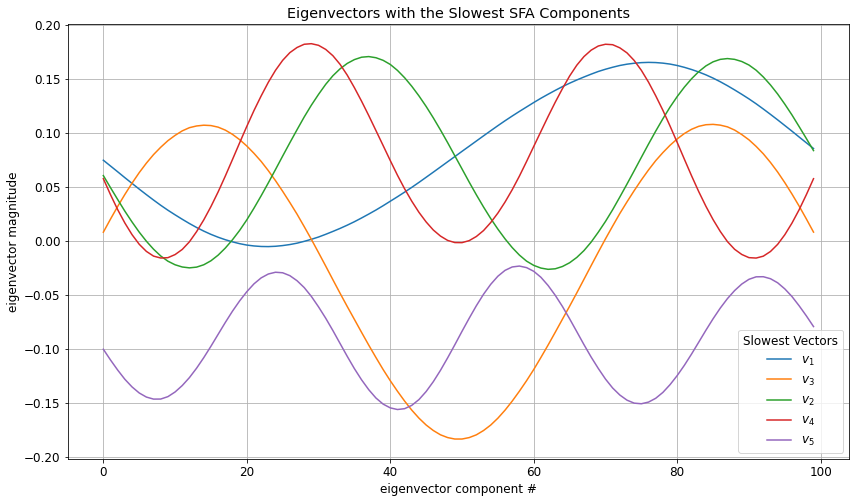

In [49]:
# using argsort from numpy
# first find the magnitude (should this include a complex part somehow?)
sort_eig_values = np.argsort(abs(eig_values))  # sort and return the index values
slowest_indices = sort_eig_values[:5]  # take out the five slowest components
for i in slowest_indices:
    plt.plot(eig_vectors[:,i], label=r'$v_{%i}$' %(i+1))  # plot the eigenvectors
plt.title('Eigenvectors with the Slowest SFA Components')
plt.ylabel('eigenvector magnitude')
plt.xlabel('eigenvector component #')
plt.legend(title='Slowest Vectors')
plt.grid()
plt.show()

### 5. How do you interpret the shape of the eigenvectors? In which way do the characteristics of the eigenvectors correspond to the intentions underlying SFA? Discuss the properties of the eigenvectors at the boundaries of the receptive fields. 

We interpret the shape of these eigenvectors as the 'slowest' as the eigenvectors have the lowest period of oscillation.

Compare this to the 'fastest' eigenvectors:

In [50]:
fastest_indices = sort_eig_values[95:]  # take out the five slowest components
for i in fastest_indices:
    plt.plot(eig_vectors[:,i], label=r'$v_{%i}$' %(i))  # plot the eigenvectors
plt.title('Eigenvectors with the Fastest Components')
plt.ylabel('eigenvector magnitude')
plt.xlabel('eigenvector component #')
plt.legend(title='Fastest Vectors')
plt.grid()
plt.show()

Our goal is therefore to inspect the slowest components of the vector that will result in the slowest components of the output signal.

For example, at a boundary of a receptive field, the stimulus will have the most abrupt change. When sliding over the edges of an image, a slow feature will respond slowly, hence the name.

### How does the shape of these eigenvectors relate to the structure of the receptive fields in primary visual cortex V1?

The shape of these eigenvectors relates to the structure of RFs in V1, where a lot of image processing occurs. Within the primary visual cortex, there are simple and complex cells. The simple cells are sensitive to the exact location of the stimulus. For the complex cells, they are invariant to stimulus shifts in their receptive field. Properties of the complex cells can be reproduced with SFA to extract features of images that change slowly.

### 6. Determine the signal in the SFA-basis $Y$ by multiplying the eigenvectors with the signal $(Y = W^T X)$. 
### Plot the five slowest components of the SFA-signal into a single graph. Did the Slow Feature Analysis succeed?

In [51]:
# calculate the SFA-basis Y
Y = eig_vectors.T @ norm_X
print('Dimensions of Y:', np.shape(Y))

Dimensions of Y: (100, 9900)


In [52]:
def plot_SFA(plot_num, x_lim):
    fig, axs = plt.subplots(plot_num, sharex=True, sharey=True)
    for i in range(plot_num):  # plot the slowest components of the signal
        axs[i].plot(Y[slowest_indices[i]], label='Component %i' %(i+1)) 
        axs[i].legend(loc=1)
        axs[i].set_ylabel('signal')
    plt.xlim(x_lim)
    plt.xlabel('image point [px]')
    plt.tight_layout()
    plt.show()

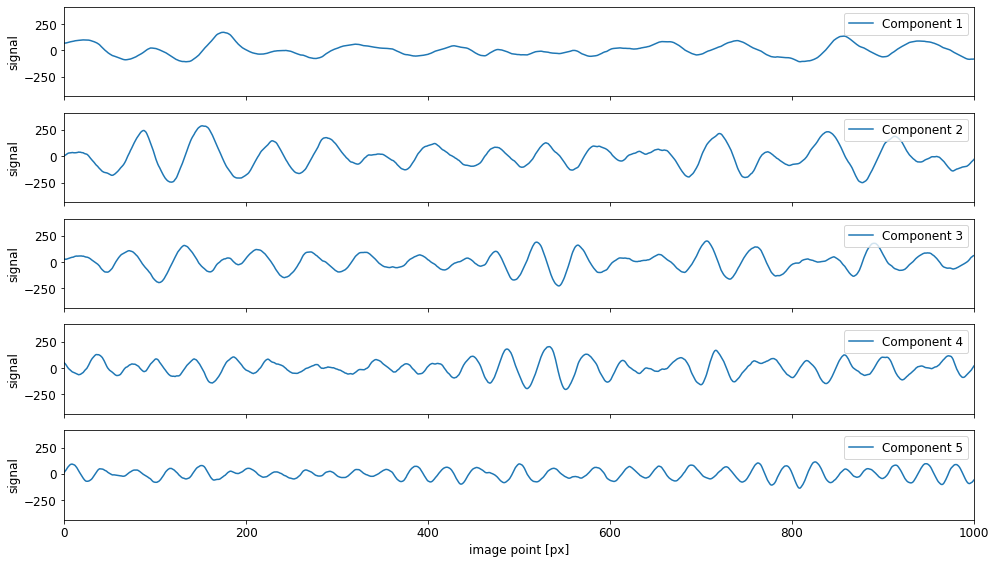

In [53]:
plot_SFA(5, (0, 1000))  # plot the 5 slowest components for a tenth of the image

I would say yes, the SFA did succeed. For correct modeling, one would want the output to be slow as well. This is shown here in the above graph.